In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
%matplotlib inline

import sys
sys.path.append('../')
from core.networks import BayesianNetwork as BN
from bayes_layer import BayesianConv2D
from bayes_layer import BayesianLinear
from bayes_layer import _calculate_fan_in_and_fan_out

In [2]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [3]:
class BayesianConvNetwork(nn.Module):
    def __init__(self, inputsize, taskcla, FC_ratio = 0.5, CNN_ratio = 0.25):
        super().__init__()
        
        ncha,size,_=inputsize
        self.taskcla = taskcla
        
        self.conv1 = BayesianConv2D(ncha,32,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(size,3, padding=1) # 32
        self.conv2 = BayesianConv2D(32,32,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 32
        s = s//2 # 16
        self.conv3 = BayesianConv2D(32,64,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 16
        self.conv4 = BayesianConv2D(64,64,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 16
        s = s//2 # 8
        self.conv5 = BayesianConv2D(64,128,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        self.conv6 = BayesianConv2D(128,128,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        self.conv7 = BayesianConv2D(128,128,kernel_size=3, padding=1, ratio = CNN_ratio)
        s = compute_conv_output_size(s,3, padding=1) # 8
        s = s//2 # 4
        self.fc1 = BayesianLinear(s*s*128,256, ratio = CNN_ratio)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.MaxPool = torch.nn.MaxPool2d(2)
        
        self.last=torch.nn.ModuleList()
        
        for t,n in self.taskcla:
            self.last.append(torch.nn.Linear(256,n))
        self.relu = torch.nn.ReLU()

    def forward(self, x, sample=False):
        h=self.relu(self.conv1(x,sample))
        h=self.relu(self.conv2(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv3(h,sample))
        h=self.relu(self.conv4(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv5(h,sample))
        h=self.relu(self.conv6(h,sample))
        h=self.relu(self.conv7(h,sample))
        h=self.drop1(self.MaxPool(h))
        h=h.view(x.shape[0],-1)
        h = self.drop2(self.relu(self.fc1(h,sample)))
        y = []
        for t,i in self.taskcla:
            y.append(self.last[t](h))
        
        return y
        

In [4]:
# class BayesianConvNetwork(nn.Module):
#     def __init__(self, inputsize, taskcla, rho_init = -4.6001):
#         super().__init__()
        
#         ncha,size,_=inputsize
#         self.taskcla = taskcla
#         self.conv1 = BayesianConv2D(ncha,32,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(size,3, padding=1) # 32
#         self.conv2 = BayesianConv2D(32,32,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 32
#         s = s//2 # 16
#         self.conv3 = BayesianConv2D(32,64,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 16
#         self.conv4 = BayesianConv2D(64,64,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 16
#         s = s//2 # 8
#         self.conv5 = BayesianConv2D(64,128,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 8
#         self.conv6 = BayesianConv2D(128,128,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 8
#         self.conv7 = BayesianConv2D(128,128,kernel_size=3, padding=1, rho_init = rho_init)
#         s = compute_conv_output_size(s,3, padding=1) # 8
#         s = s//2 # 4
        
#         self.fc1 = BayesianLinear(s*s*128,256, rho_init = rho_init) # 2048
#         self.drop1 = nn.Dropout(0.25)
#         self.drop2 = nn.Dropout(0.5)
#         self.MaxPool = torch.nn.MaxPool2d(2)
        
#         self.last=torch.nn.ModuleList()
        
#         for t,n in self.taskcla:
#             self.last.append(torch.nn.Linear(256,n))
#         self.relu = torch.nn.ReLU()

#     def forward(self, x, sample=False):
#         h=self.relu(self.conv1(x,sample))
#         h=self.relu(self.conv2(h,sample))
#         h=self.drop1(self.MaxPool(h))
#         h=self.relu(self.conv3(h,sample))
#         h=self.relu(self.conv4(h,sample))
#         h=self.drop1(self.MaxPool(h))
#         h=self.relu(self.conv5(h,sample))
#         h=self.relu(self.conv6(h,sample))
#         h=self.relu(self.conv7(h,sample))
#         h=self.drop1(self.MaxPool(h))
#         h=h.view(x.shape[0],-1)
#         h = self.drop2(self.relu(self.fc1(h,sample)))
#         y = []
#         for t,i in self.taskcla:
#             y.append(self.last[t](h))
        
#         return y

In [5]:
def weight_channel_wise_histogram(model_name, ratio=None, std_init=None):
    cnt = 0
    sample_num = []
#     taskcla = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10,10)]
#     task_num = 11
    taskcla = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10)]
    task_num = 10
    
    model = BayesianConvNetwork((3,32,32),taskcla)
    rand_std = []
    for (_, layer) in model.named_children():
        if isinstance(layer, BayesianLinear) == False and isinstance(layer, BayesianConv2D) == False:
            continue
        out_features = layer.weight_rho.shape[0]
        
        sample_num.append(out_features)
        std_arr = np.zeros((sample_num[cnt], task_num+1))
#         std_arr = np.zeros((sample_num[cnt], task_num))
        rand_idx = np.arange(out_features)
        np.random.shuffle(rand_idx)
        rand_idx = np.sort(rand_idx[:sample_num[cnt]])
        
        if ratio is not None:
            fan_in, fan_out = _calculate_fan_in_and_fan_out(layer.weight_mu)
            if isinstance(layer, BayesianLinear):
                noise_var = (2/fan_in) * ratio
            elif isinstance(layer, BayesianConv2D):
                noise_var = (2/fan_out) * ratio
            std_init = math.sqrt(noise_var)
        
        std_arr[:,0] = np.ones(sample_num[cnt]) * std_init
        for t in range(task_num):
            model.load_state_dict(torch.load(model_name%t))
            
            std = np.log(1+np.exp(layer.weight_rho.data.cpu().numpy())).reshape((out_features))
            std = np.sort(std)
            std_arr[:,t+1] = std[rand_idx]
#             std_arr[:,t] = std[rand_idx]
            
        reg_arr = (std_init/std_arr)**2
        rand_std.append(std_arr)
#         rand_std.append(reg_arr)
        cnt += 1
        
    
    plt.figure(figsize=(21,18))
    for l in range(cnt):
#         plt.figure(figsize=(15,5))
        plt.subplot(3,3,l+1)
        
        for i in range(sample_num[l]):
            plt.plot(np.arange(task_num+1), rand_std[l][i], linestyle = '-')
#             plt.plot(np.arange(task_num), rand_std[l][i], linestyle = '-')

        fontsize = 20
        plt.xticks(np.arange(task_num+1),fontsize = fontsize)
#         plt.xticks(np.arange(task_num),fontsize = fontsize)
        plt.yticks(fontsize = 15)

        plt.xlabel('Task', fontsize = fontsize)
        if l==0:
            plt.ylabel('STD',fontsize = fontsize)
#             plt.ylabel('Strength',fontsize = fontsize)
        
#         plt.ylim(0,100)
        
        plt.title('Layer %d'%(l+1), fontsize = fontsize)
        plt.tight_layout()

#     plt.savefig('figure/histogram_layer.pdf', bbox_inches='tight')

In [6]:
def avg_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    avg_acc_arr = np.zeros(tasknum)
    for i in range(tasknum):
        avg_acc_arr[i] = np.mean(acc_arr[i][:i+1])
    
    return avg_acc_arr

In [7]:
def test_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    return acc_arr

In [8]:
seed_num = 1
UCL = {}
beta_arr = [1e-4,2e-4,3e-4,5e-4,1e-3,6e-4,7e-4,8e-4,9e-4,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,1e-2,2e-2]
ratio_arr = [1/4,1/8,1/16]
lr_rho_arr = [5e-3,6e-3,7e-3,8e-3,9e-3,10e-3,11e-3,12e-3,13e-3,14e-3,15e-3,16e-3,17e-3,18e-3,19e-3,20e-3]
name = 'CIFAR10_100_split_cifar10_100_baye_{}_beta_{:.7f}_FC_{:.7f}_CNN_{:.7f}_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'
for beta in beta_arr:
    UCL[beta] = {}
    for ratio in ratio_arr:
        UCL[beta][ratio] = {}
        for lr_rho in lr_rho_arr:
            UCL[beta][ratio][lr_rho] = np.zeros((seed_num, 11))
            for seed in range(seed_num):
                UCL[beta][ratio][lr_rho][seed] = avg_acc(name.format(seed,beta,ratio, ratio, lr_rho), tasknum=11)

In [9]:
# UCL_std = {}
# beta_arr = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3]
# std_arr = [0.01,0.02,0.03]
# lr_rho_arr = [1e-3,3e-3,5e-3]
# name = 'CIFAR10_100_split_cifar10_100_baye_{}_beta_{:.7f}_std_{:.3f}_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'
# for beta in beta_arr:
#     UCL_std[beta] = {}
#     for std in std_arr:
#         UCL_std[beta][std] = {}
#         for lr_rho in lr_rho_arr:
#             UCL_std[beta][std][lr_rho] = np.zeros((seed_num, 11))
#             for seed in range(seed_num):
#                 UCL_std[beta][std][lr_rho][seed] = avg_acc(name.format(seed,beta,std,lr_rho), tasknum=11)

In [10]:
EWC = {}
lamb_arr = [0,500,1000,3000,5000,7000,9000,10000,30000,50000,70000,90000]
name = 'CIFAR_10_100_split_cifar10_100_ewc_with_log_{}_lamb_{:.1f}_unitN_400_batch_256_epoch_100_conv.txt'
for lamb in lamb_arr:
    EWC[lamb] = np.zeros((seed_num, 11))
    for seed in range(seed_num):
        EWC[lamb][seed] = avg_acc(name.format(seed,lamb), tasknum=11)

In [11]:
SI = {}
c_arr = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1.0]
name = 'CIFAR10_100_split_cifar10_100_si_with_log_{}_c_{:.1f}_unitN_400_batch_256_epoch_100_conv.txt'
for c in c_arr:
    SI[c] = np.zeros((seed_num, 11))
    for seed in range(seed_num):
        SI[c][seed] = avg_acc(name.format(seed, c), tasknum=11)

[0.8204     0.77635    0.74966667 0.7529     0.74616    0.73061667
 0.72407143 0.7227875  0.72163333 0.72894    0.7265    ]


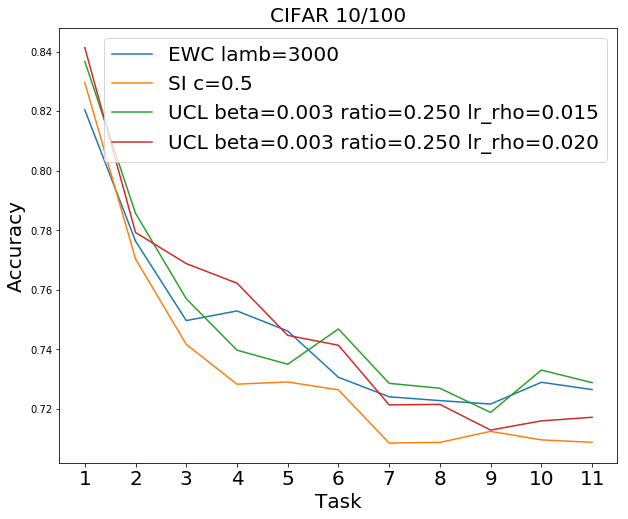

In [12]:


task = np.arange(11) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC[3000], axis = 0), linestyle='-', label='EWC lamb=3000')
plt.plot(task, np.mean(SI[0.5], axis = 0), linestyle='-', label='SI c=0.5')

ratio = 1/4
lr_rho = 8e-3

beta_arr = [
    1e-4,
    2e-4,
    3e-4,
    5e-4,
    6e-4,
    7e-4,
    8e-4,
    9e-4,
    1e-3,
    2e-3,
    3e-3,
    4e-3,
    5e-3,
    6e-3,
    7e-3,
    8e-3,
    9e-3,
    1e-2,
    2e-2,
    4e-2,
    5e-2,
    6e-2
]


lr_rho_arr = [
#     5e-3,
#     6e-3,
#     7e-3,
#     8e-3,
#     9e-3,
#     10e-3,
#     11e-3,
#     12e-3,
#     13e-3,
#     14e-3,
    15e-3,
#     16e-3,
#     17e-3,
#     18e-3,
#     19e-3,
    20e-3
]

beta = 3e-3
ratio = 1/4

for lr_rho in lr_rho_arr:
    plt.plot(task, np.mean(UCL[beta][ratio][lr_rho], axis = 0), linestyle='-', label='UCL beta=%.3f ratio=%.3f lr_rho=%.3f'%(beta,ratio,lr_rho))



plt.xticks([1,2,3,4,5,6,7,8,9,10,11],fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.7,0.84)
# plt.yticks([0.70,0.72,0.74,0.76,0.78,0.80,0.82,0.84], fontsize = 20)
plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=20)

# print(np.mean(EWC[3000], axis = 0))
# print(np.mean(UCL[0.003][1/4][0.015], axis = 0))

print(np.mean(EWC[3000], axis = 0))


In [13]:
sns.set_palette(sns.color_palette("husl", 100))

In [14]:
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0030000_FC_0.2500000_CNN_0.2500000_lr_rho_0.015_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)

In [15]:
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0030000_FC_0.2500000_CNN_0.2500000_lr_rho_0.016_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)

In [16]:
# name = '../models/trained_model/CIFAR10_100_split_cifar10_100_baye_0_beta_0.0030000_FC_0.2500000_CNN_0.2500000_lr_rho_0.015_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
# weight_channel_wise_histogram(name, ratio=1/4)

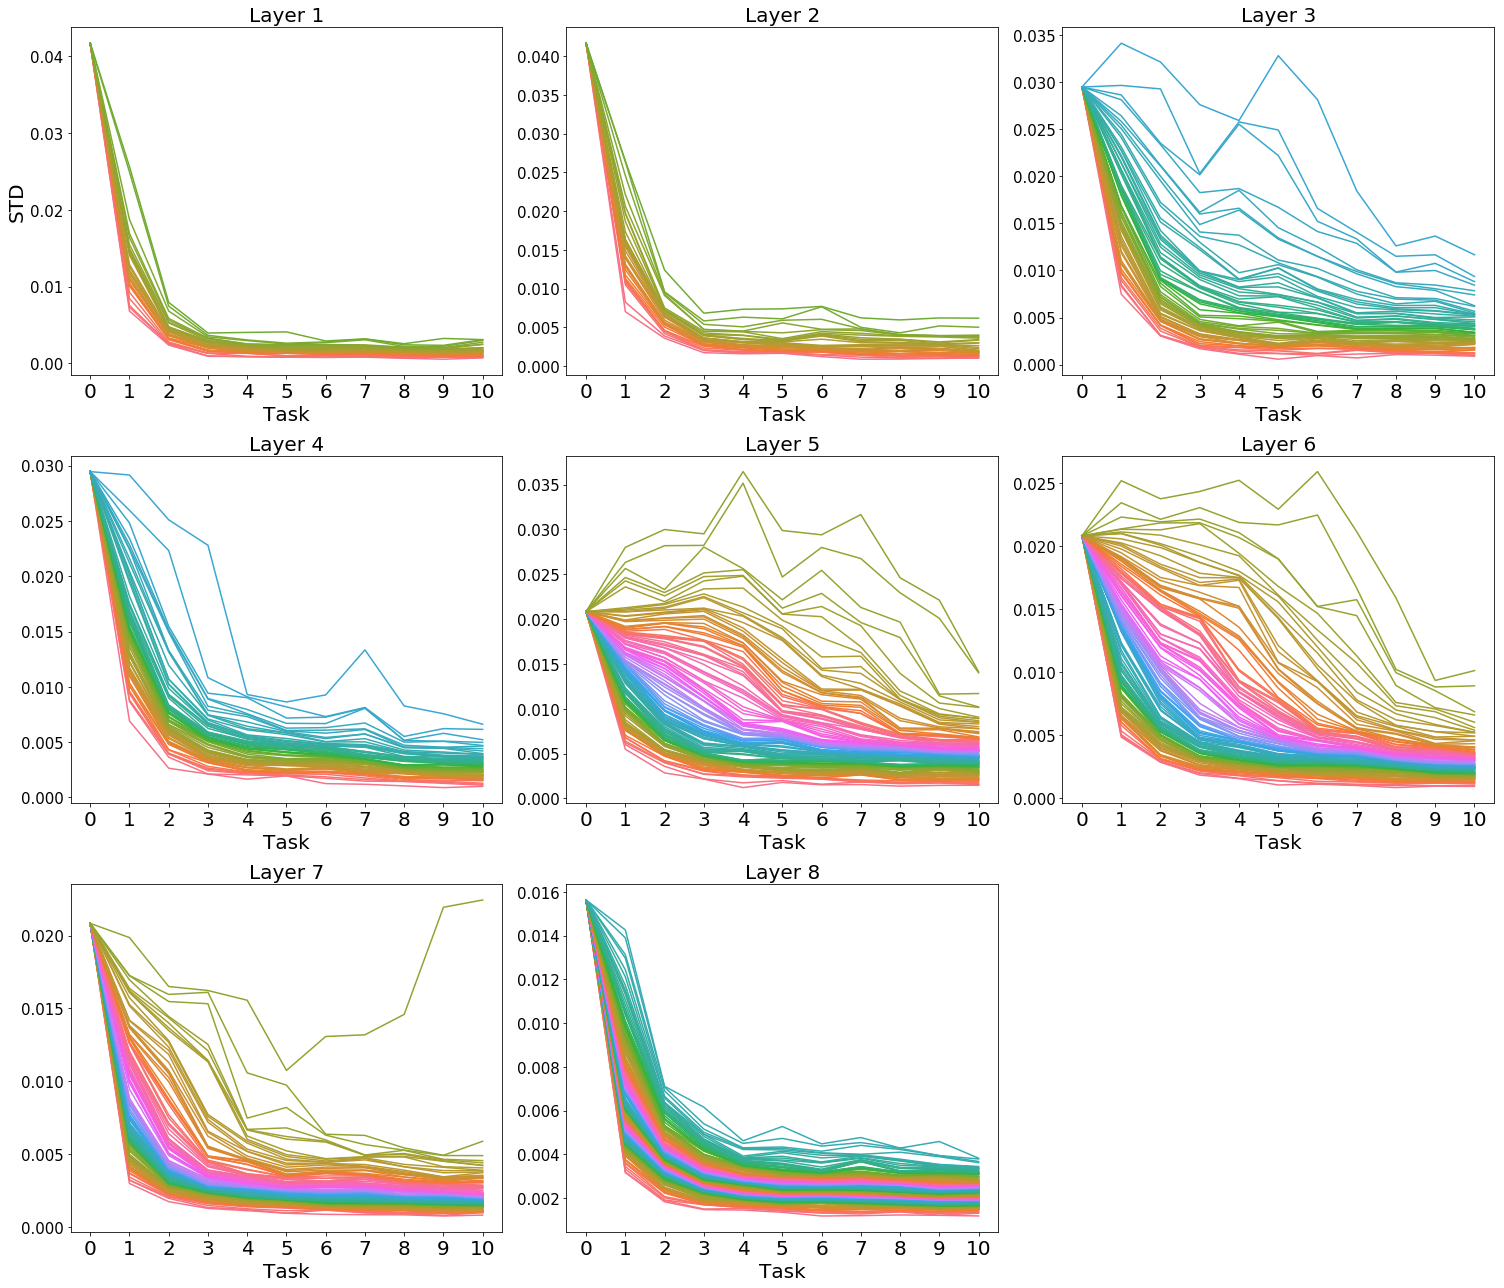

In [18]:
name = '../models/trained_model/CIFAR_100_split_cifar100_baye_0_beta_0.0020000_FC_0.2500000_CNN_0.2500000_lr_rho_0.02_unitN_400_batch_256_epoch_100_conv_task_%d.pt'
weight_channel_wise_histogram(name, ratio=1/4)